# Data visualization unthrottled:
Unthrottled memory power = ~3000

| # | Setting |
| --- | --- |
| Device | macbook pro 14-inch, 2023 | 
| Chip | Apple M2 Pro | 
| Memory | 16 GB | 
| macOS | 15.1.1 | 
| Java | openjdk 21.0.5 | 
| Node | v23.3.0 | 
| Angular | v18.2.x |

## Core Web Vitals Measurements:

**Long task**
- Task that takes more than 50ms

**TTFB (Time to First Byte):**
 - Time from navigation start until the first byte of response is received
 - Calculated using: performance.getEntriesByType('navigation')[0].responseStart
 
**FCP (First Contentful Paint):**
 - Time when the first text, image, or other content appears on the screen.
 - Is the 'endTime' of the first-contentful-paint
 - FCP includes all things that happened before it (like TTFB).
 
**LCP (Largest Contentful Paint):**
 - Time when the largest text or image element is rendered on the screen (so endTime)
 - Is the 'endTime' of the largest-contentful-paint.
 - FCP includes all things that happened before it (like TTFB).
 
**TTI (Time to Interactive):**
 - Time when the page becomes 'reliably' interactive
 - It is measured as the endtime of the last 'long task' after the FCP starttime
 - If no tasks are found, it is the end-time of the FCP.
 
**TBT (Total Blocking Time):**
 - Sum of all "blocking time" for long tasks between start of FCP and TTI
 - Blocking time = accumulation of (task duration - 50ms) of each long task.
 - TBT contains a 'quiet window' of 5s, if this window is expired, the test will end.
 - The quiet window starts after the FCP. 

In [76]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

csr_dataset = pd.read_csv('../data/results-csr.csv', sep=',')
ssr_dataset_h = pd.read_csv('../data/results-ssr-h.csv', sep=',')
ssr_dataset_v = pd.read_csv('../data/results-ssr-v.csv', sep=',')

datasets =	{
  "csr": csr_dataset,
  "ssr h": ssr_dataset_h,
  "ssr v": ssr_dataset_v,
}

csr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site         60 non-null     object 
 1   date         60 non-null     object 
 2   time         60 non-null     object 
 3   navTime      60 non-null     int64  
 4   totalTime    60 non-null     int64  
 5   lcp          60 non-null     float64
 6   fcp          60 non-null     float64
 7   ttfb         60 non-null     float64
 8   tbt          60 non-null     int64  
 9   tti          60 non-null     float64
 10  longTasks    60 non-null     int64  
 11  longestTask  60 non-null     int64  
 12  error        0 non-null      float64
dtypes: float64(5), int64(5), object(3)
memory usage: 6.2+ KB


## Comparing the datasets

This table shows the overal metrics of the 2 paradigms and their major differences.

In [77]:
features = ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'longTasks', 'longestTask']
headers = ["feature","dataset","Tests", "min", "1st Qrt.", "mean", "median", "3rd Qrt.", "max", "std dev."] 
report = []

for f in features:
  for d in datasets:
    report.append([
        f,
        d,
        datasets[d][f].size,
        datasets[d][f].min(),
        datasets[d][f].quantile(0.25),
        datasets[d][f].mean(),
        datasets[d][f].median(),
        datasets[d][f].quantile(0.75),
        datasets[d][f].max(),
        datasets[d][f].std(),
    ])

pd.DataFrame(report, columns=headers)

,feature,dataset,Tests,min,1st Qrt.,mean,median,3rd Qrt.,max,std dev.
0,navTime,csr,60,706.00,731.00,742.38,737.50,748.25,950.00,31.76
1,navTime,ssr h,60,737.00,754.50,780.58,767.00,792.25,1205.00,61.91
2,navTime,ssr v,60,628.00,637.00,643.05,640.00,648.25,669.00,9.78
3,totalTime,csr,60,5719.00,5742.00,5753.87,5747.50,5760.25,5960.00,31.59
4,totalTime,ssr h,60,5750.00,5767.75,5793.33,5780.50,5802.50,6222.00,62.52
5,totalTime,ssr v,60,5639.00,5648.00,5654.93,5653.00,5661.00,5685.00,10.57
6,lcp,csr,60,251.20,267.98,280.26,276.00,287.72,479.30,29.34
7,lcp,ssr h,60,204.60,223.68,243.15,235.70,239.50,659.40,58.34
8,lcp,ssr v,60,74.50,86.60,91.73,89.35,98.53,109.10,8.12
9,fcp,csr,60,62.20,80.95,90.55,88.00,98.65,229.30,22.76


The following boxplots will show the outliers and visualizes the overal differences between the paradigms

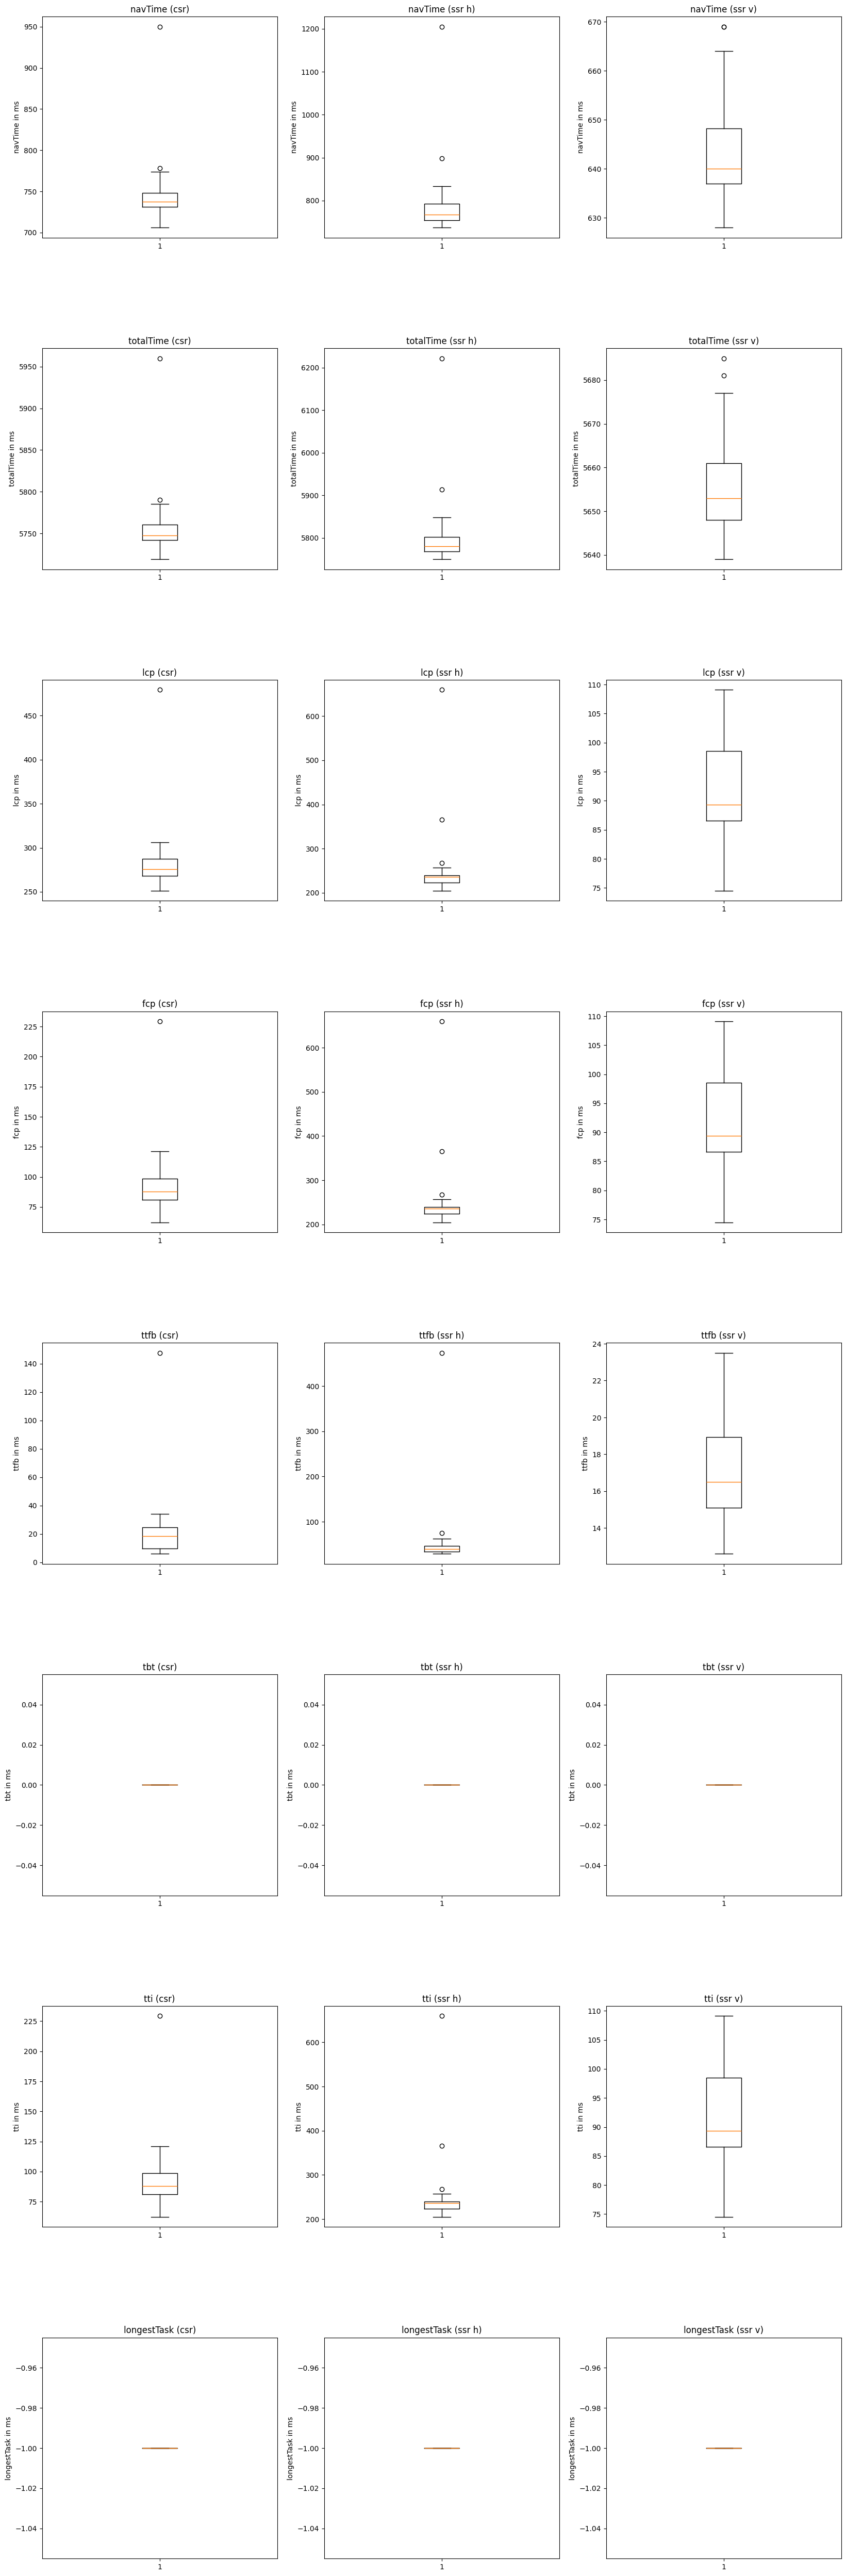

In [78]:
def plot_box_plot(d, f, loc):
    data = datasets[d][f]
    loc.boxplot(data, vert=True)
    loc.set_title(f + ' (' + d + ')')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_box_plot, ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

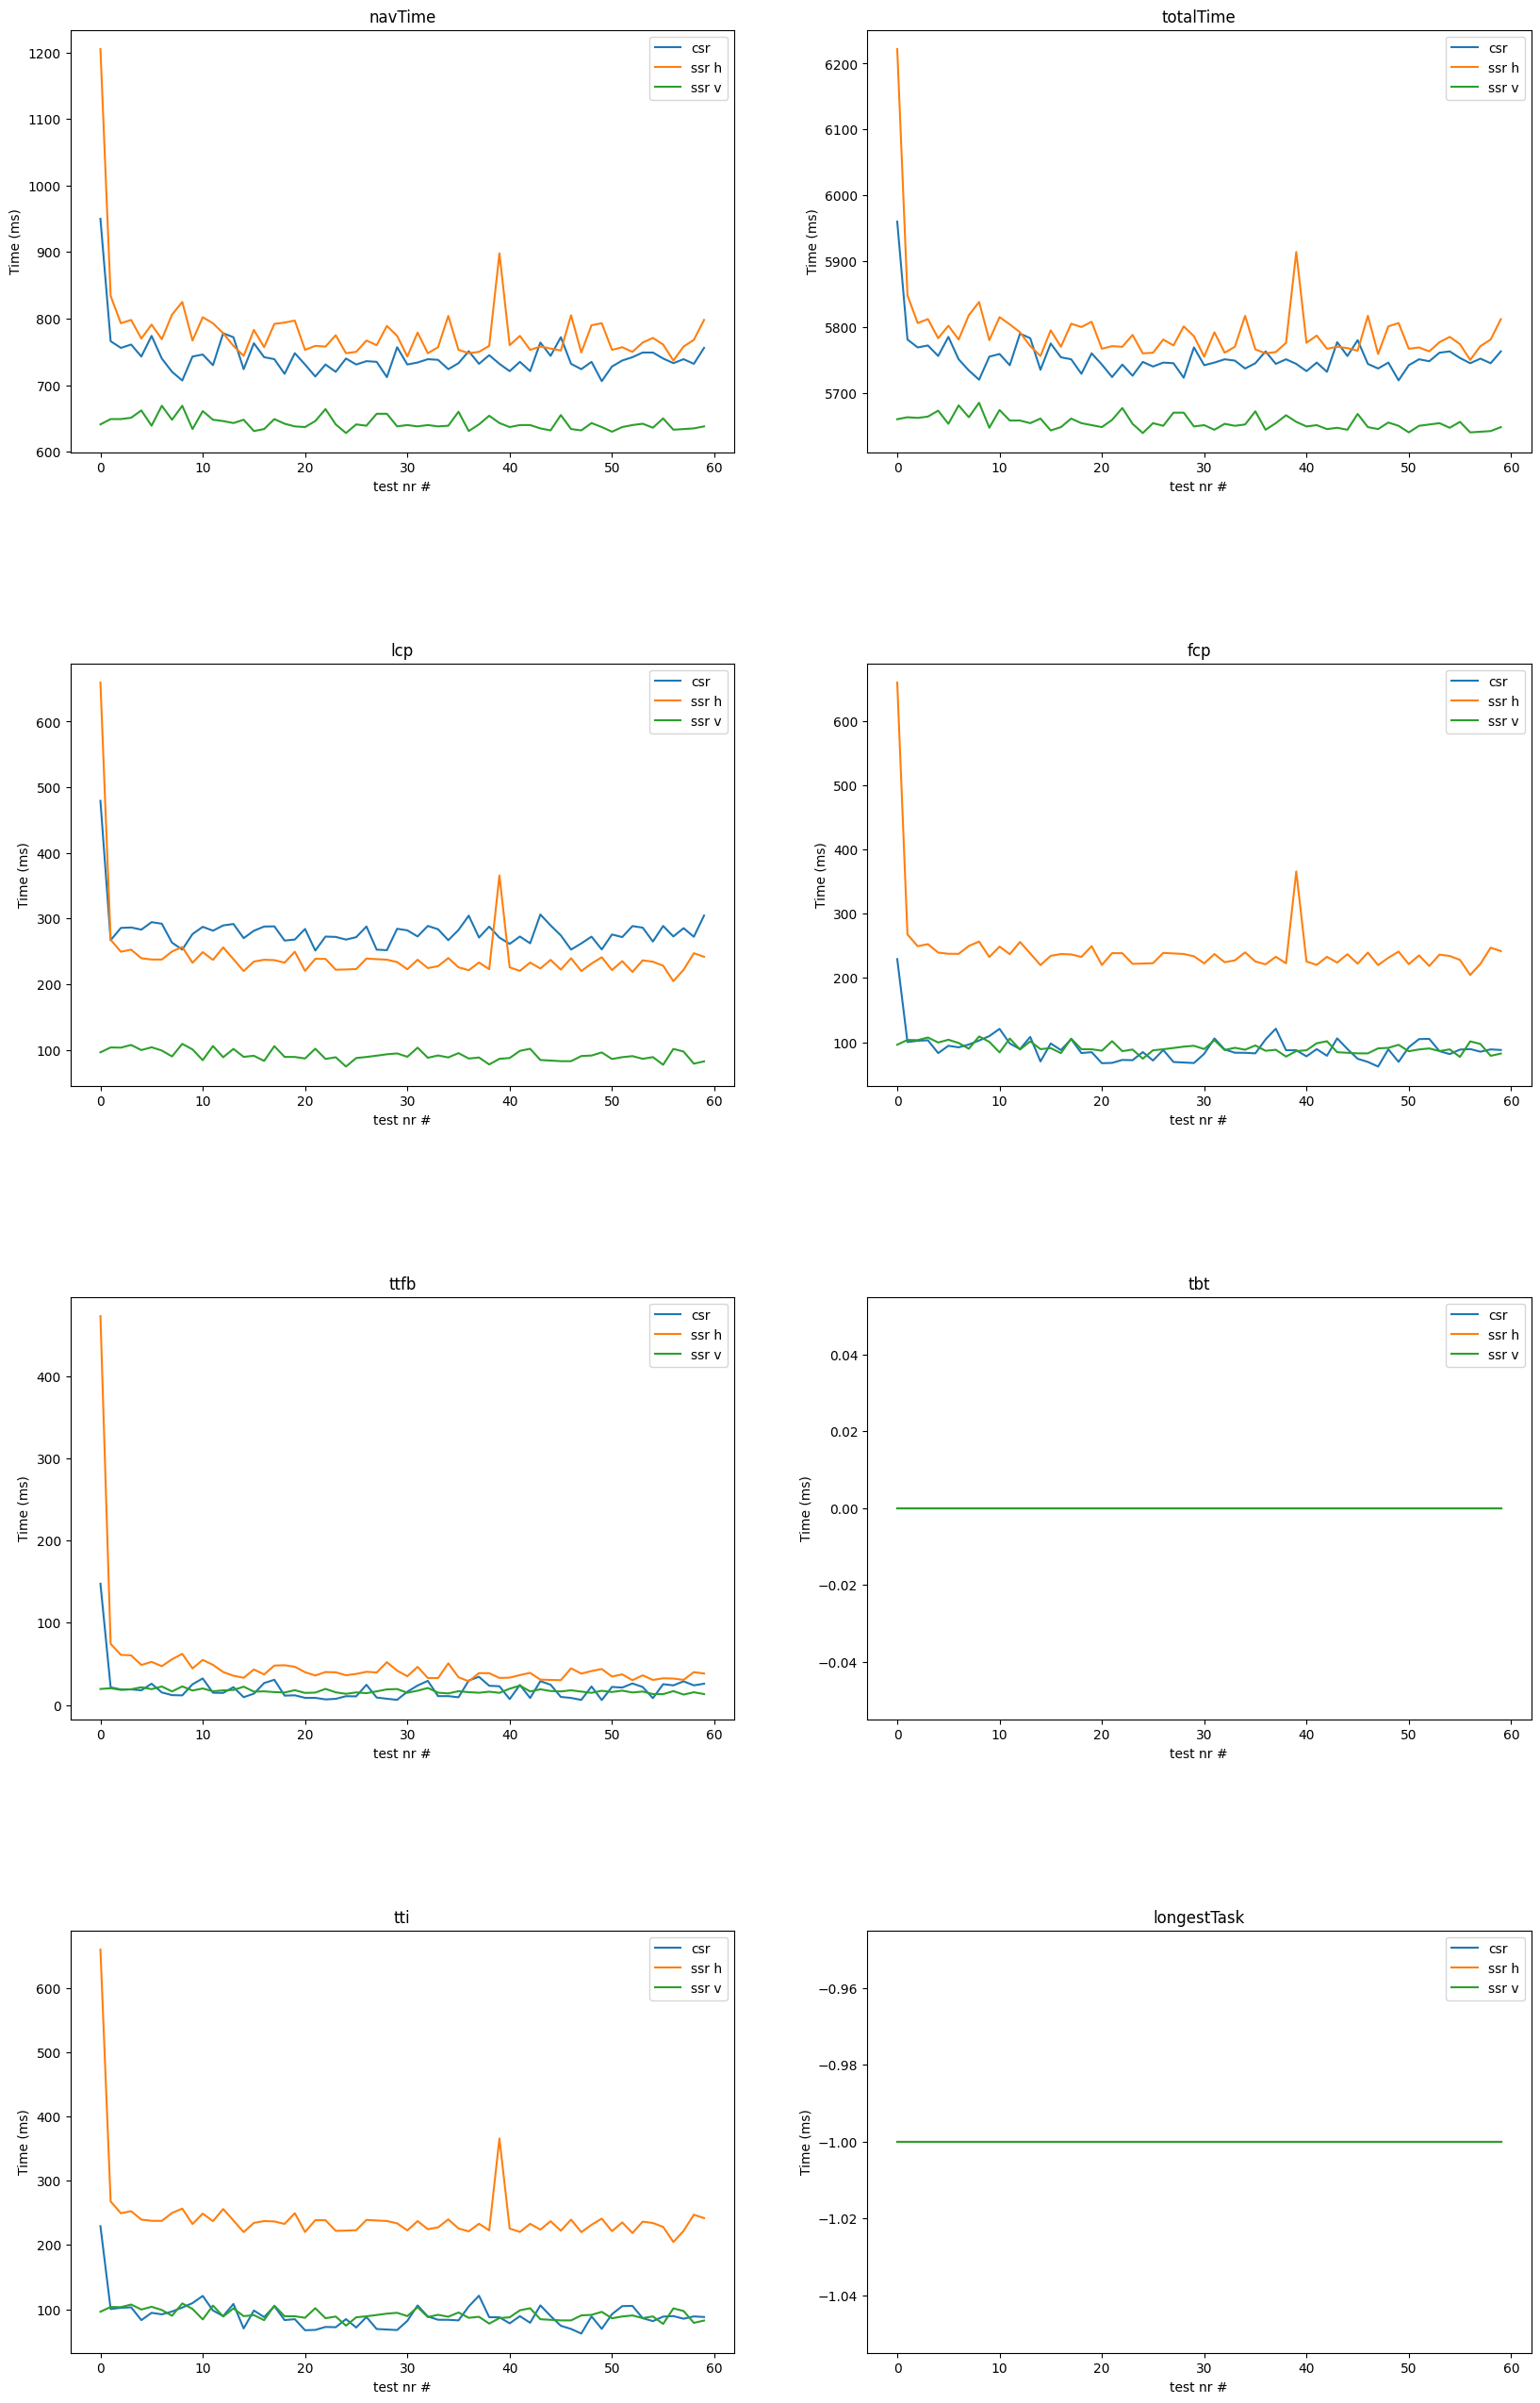

In [79]:
def ceildiv(a, b): return -(a // -b)

def plot_line_graph(feature, loc):
    for d in datasets:
        loc.plot(datasets[d][feature], label=d)
    
    loc.set_title(feature)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 

    loc.legend()
    


def graphs(plot_func, features,cols=2, height=8):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt

graphs(plot_line_graph, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])

Outliers were removed using IQR (So all the white circles in the boxplots were removed since they represent noise)

In [80]:
JVM_WARMUP_ROUNDS = 5
IQR_MULTIPLIER = 3

def find_outlier_indices(df, features):
    outlier_indices = set()
    for feature in features:
        Q1, Q3 = df[feature].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        bounds = Q1 - (IQR * IQR_MULTIPLIER), Q3 + (IQR * IQR_MULTIPLIER)
        outlier_indices.update(df[(df[feature] < bounds[0]) | (df[feature] > bounds[1])].index)
    return outlier_indices

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'longTasks', 'longestTask']
datasets = {k: df.iloc[JVM_WARMUP_ROUNDS:] for k, df in datasets.items()} 

all_outlier_indices = set().union(*[find_outlier_indices(df, features) for df in datasets.values()])

sizes_data = [[
    k, 
    (org_len := len(df) + JVM_WARMUP_ROUNDS), 
    (new_len := len(df_clean := df.drop(index=all_outlier_indices))), 
    100 - ( (new_len / org_len) * 100)
] for k, df in datasets.items()]
datasets = {k: df.drop(index=all_outlier_indices).reset_index(drop=True) for k, df in datasets.items()}

result_df = pd.DataFrame(sizes_data, columns=['Dataset', 'Original size', 'Size without outliers', '% removed'])

result_df

,Dataset,Original size,Size without outliers,% removed
0,csr,60,54,10.00
1,ssr h,60,54,10.00
2,ssr v,60,54,10.00


## Detailed comparison
The line graphs and box-plots show a more detailed overview of the differences between SSR and CSR

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

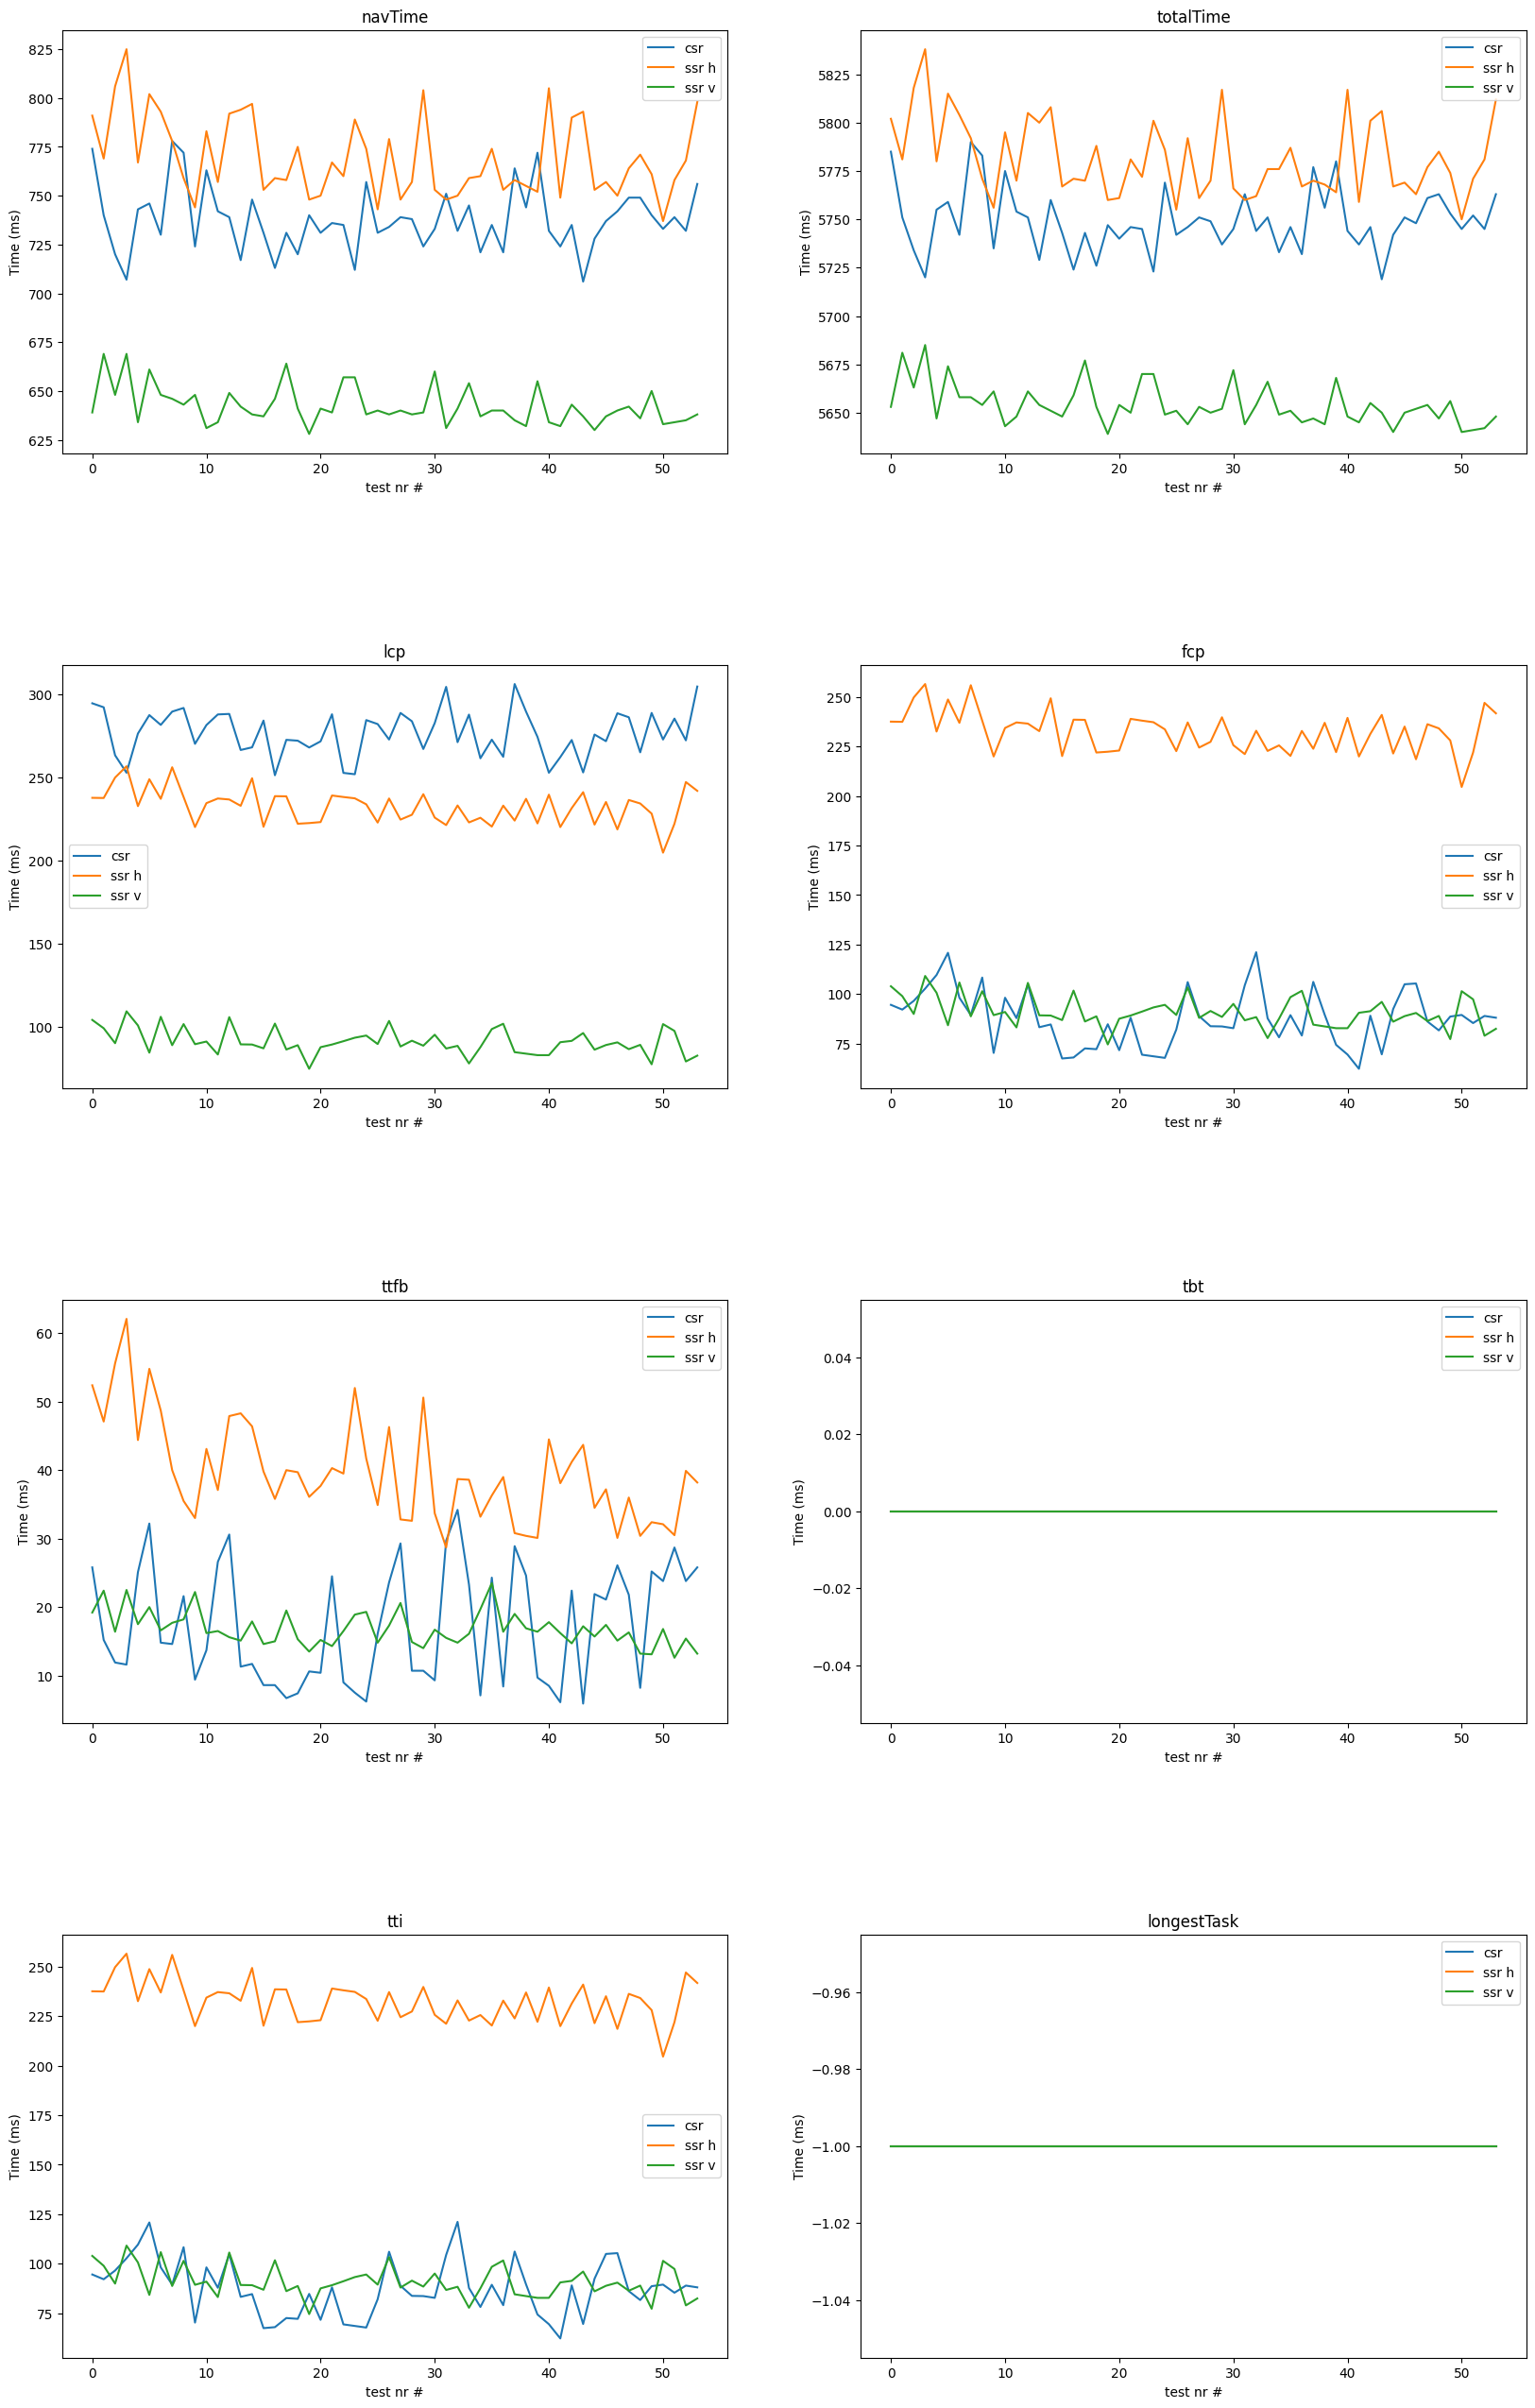

In [81]:
def ceildiv(a, b): return -(a // -b)

def plot_line_graph(feature, loc):
    for d in datasets:
        loc.plot(datasets[d][feature], label=d)
    
    loc.set_title(feature)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 

    loc.legend()
    

def graphs(plot_func, features,cols=2, height=8):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt

graphs(plot_line_graph, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])



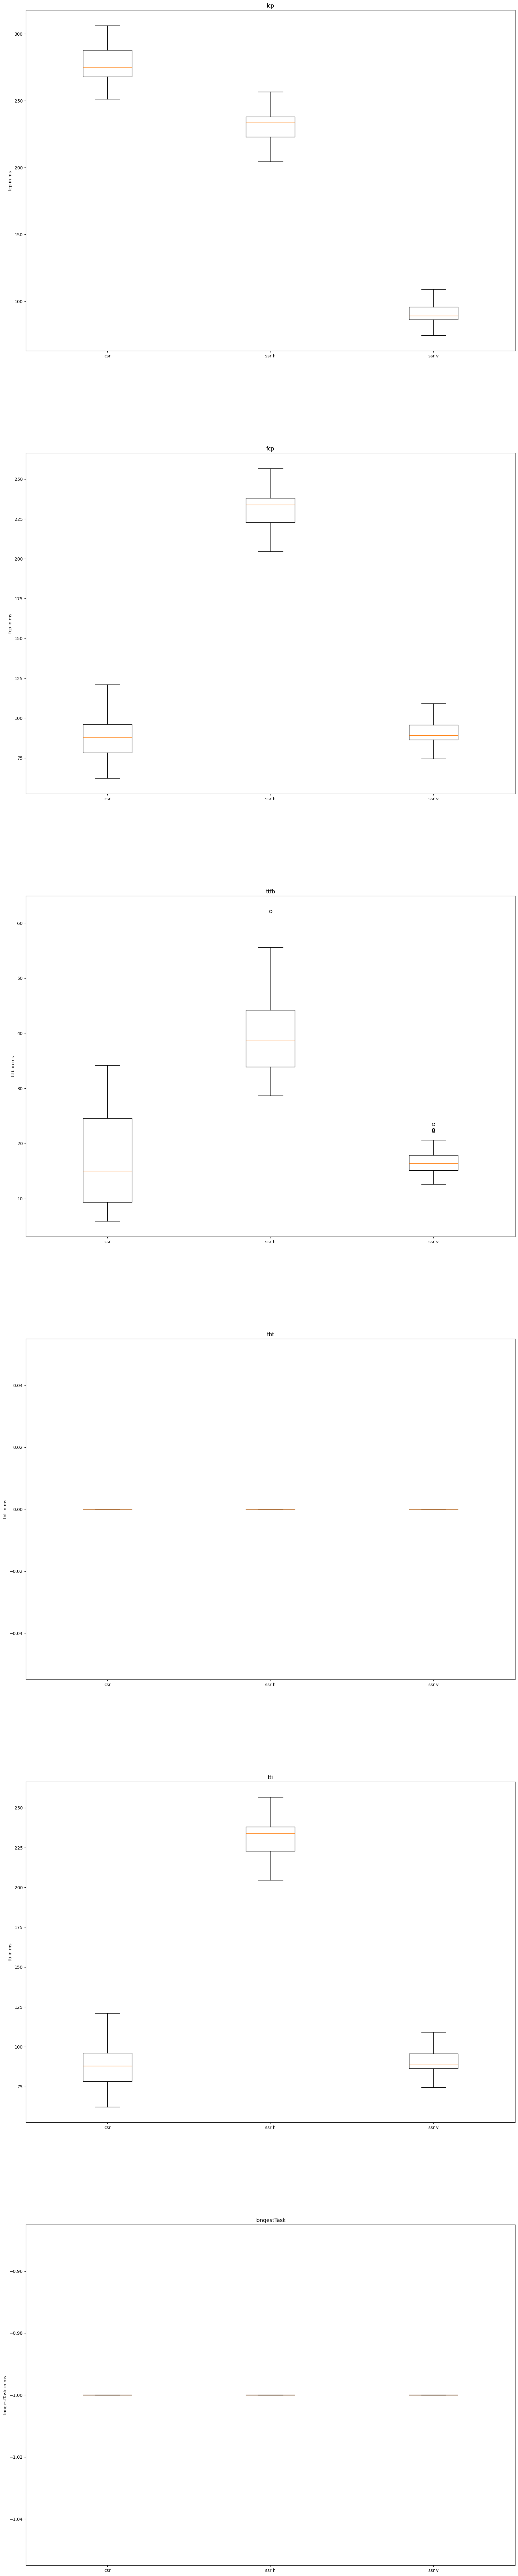

In [82]:
def plot_box_plot(f, loc):
    data = [datasets[d][f] for d in datasets]
    loc.boxplot(data, tick_labels=datasets.keys())
    loc.set_title(f)
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=15):
    rows = len(features)
    cols = 1  

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

plt = graphs(plot_box_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

## Correlations
The scatter charts show the relationships between the metrics and the overal time of the test.

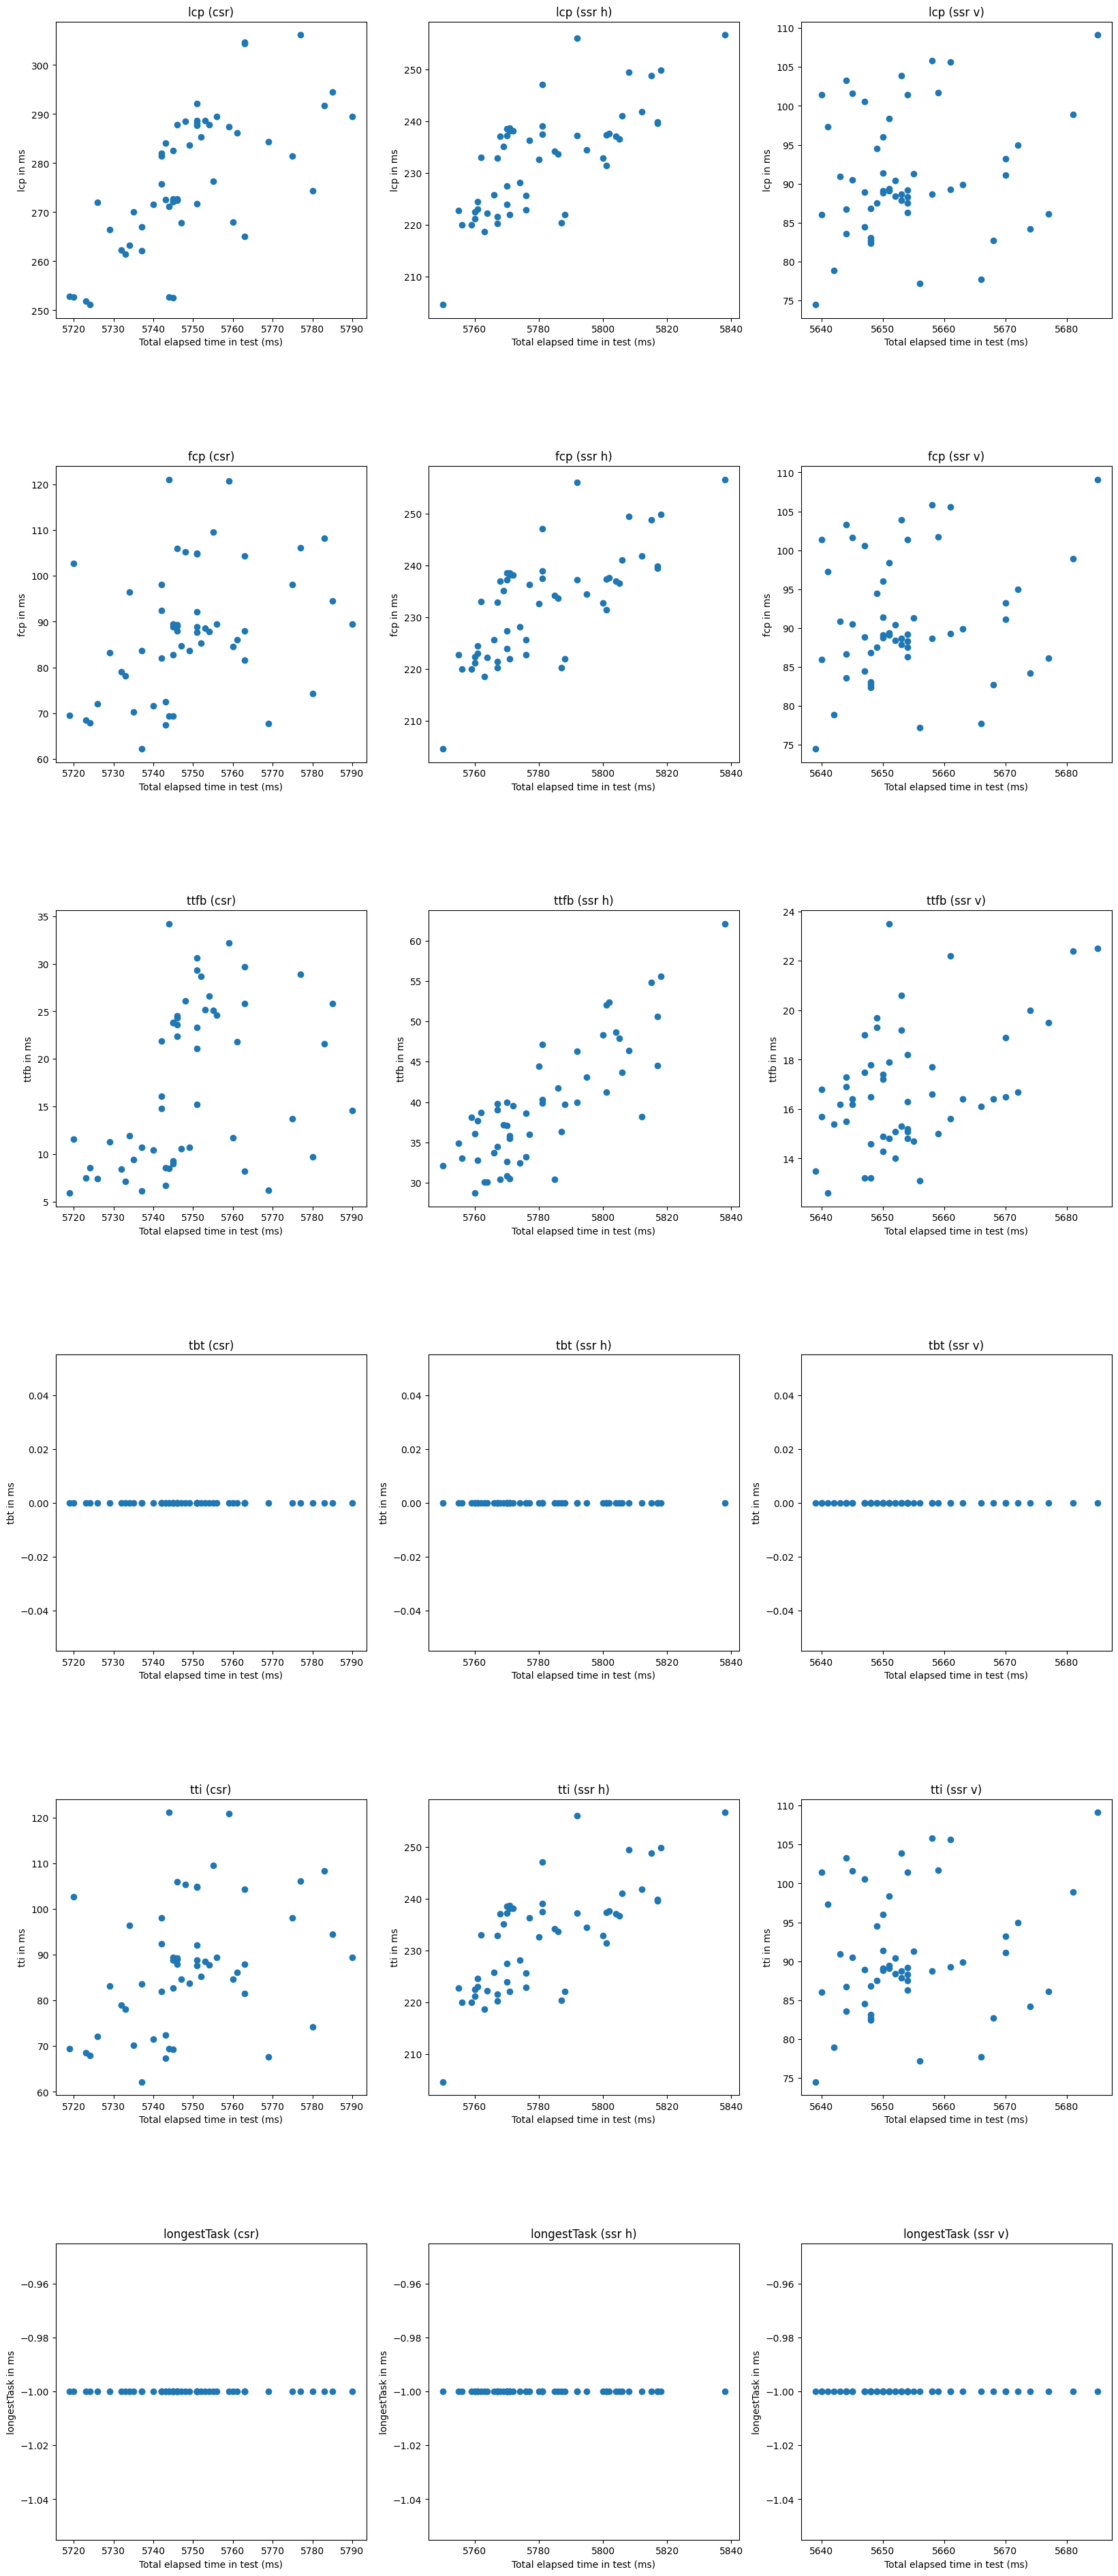

In [83]:
def plot_scatter_plot(d, f, loc):
    loc.scatter(datasets[d]['totalTime'], datasets[d][f], label=d)
    loc.set_title(f + ' (' + d + ')')
    loc.set_xlabel('Total elapsed time in test (ms)')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_scatter_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()


## Frequencies
The histograms show the frequencies of the certain values

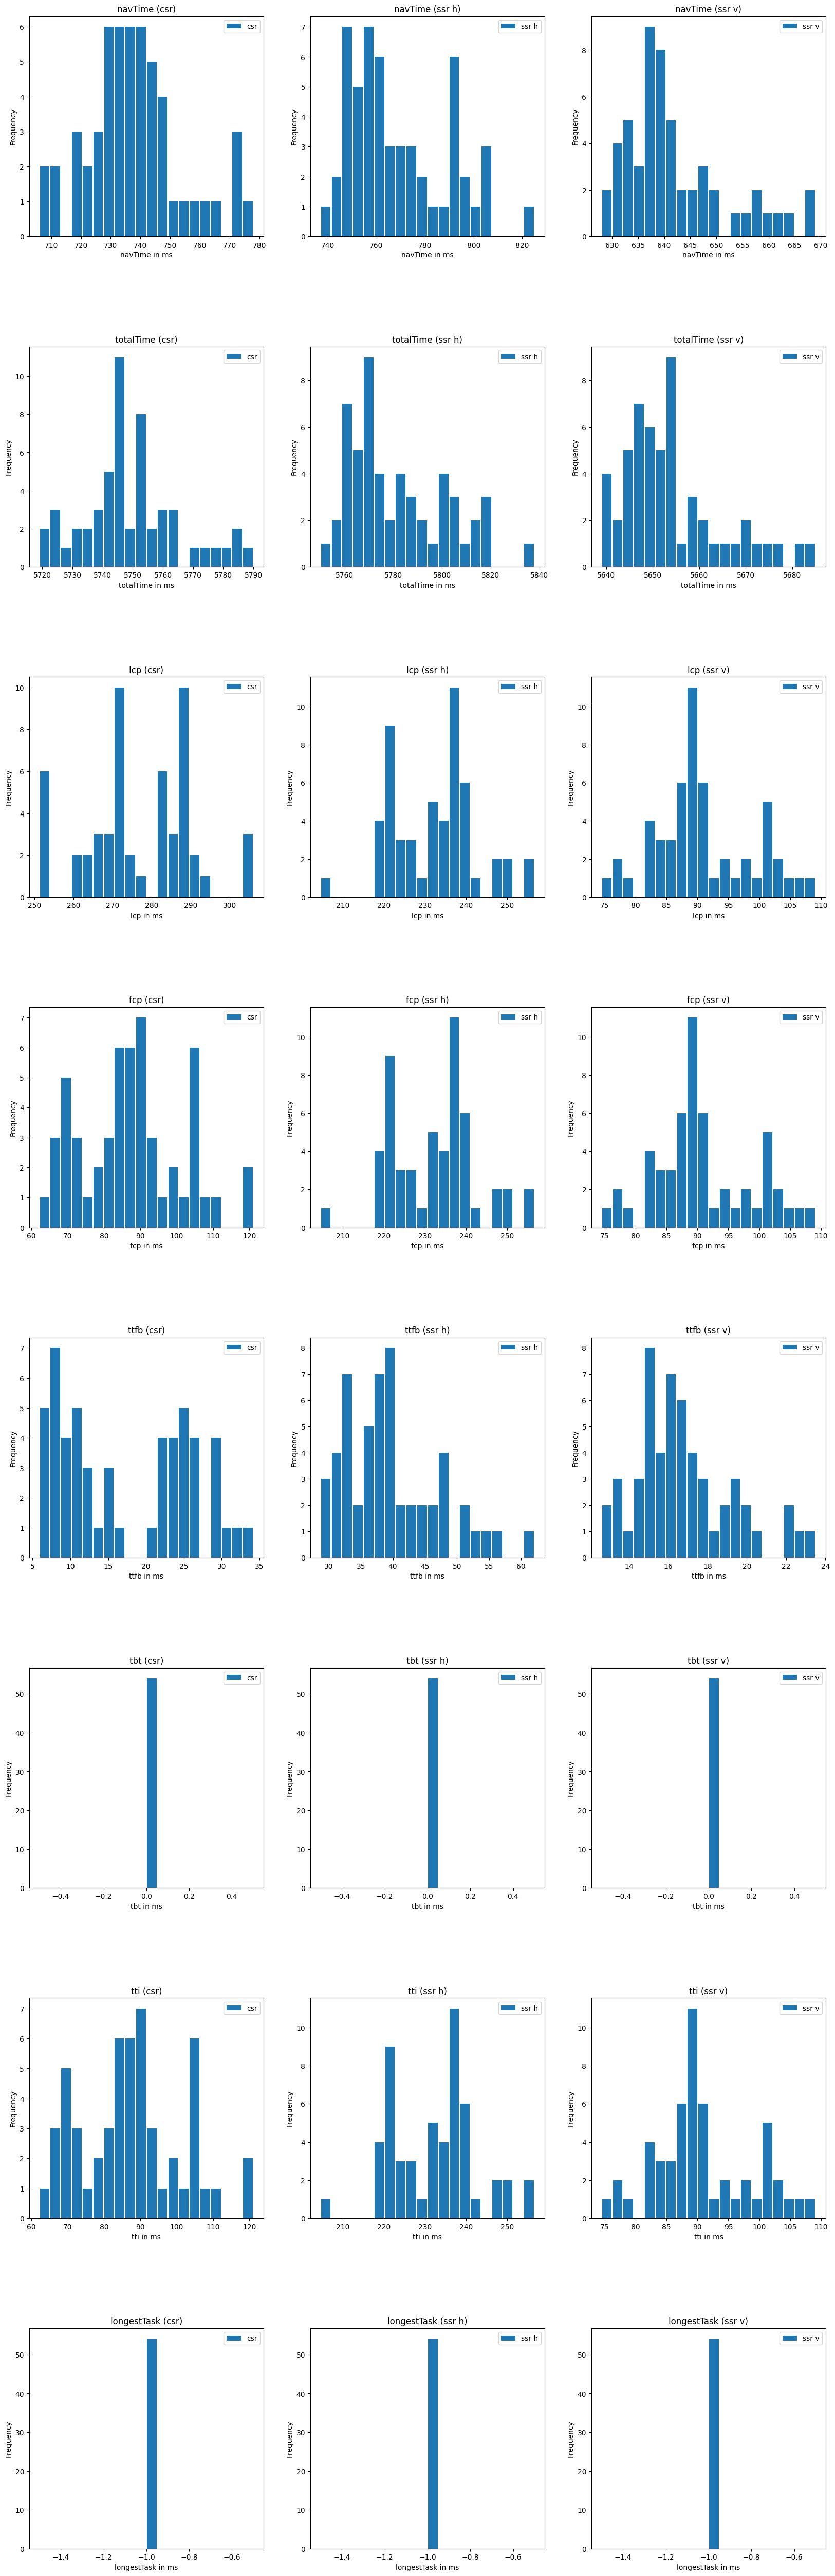

In [84]:
def plot_histogram(d, f, loc):
    data = datasets[d][f].sort_values()
    data.plot(kind='hist', ax=loc, title=f, rwidth=0.9, bins=20)
    loc.set_xlabel(f + ' in ms')
    loc.set_ylabel('Frequency')
    loc.set_title(f + ' (' + d + ')')
    loc.legend([d])

def graphs(plot_func, features,height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_histogram, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()